In [101]:
import tensorflow as tf
import pandas as pd
import numpy as np
import jieba
import re
from gensim.models import word2vec

In [102]:
train_data = pd.read_csv('data/train.tsv', sep='\t',header=0)
test = pd.read_csv('data/test.tsv', sep='\t',header=0)
train_data = pd.concat([train_data, test])

In [103]:
train_data = train_data.drop(['index'],axis=1)
train_data = train_data.drop(['question'],axis=1)
train_data = train_data.reset_index()

In [104]:
# 建立停用词表
stopwords = [line.strip() for line in open('hit_stop_word.txt', 'r', encoding='utf-8').readlines()]
others = ['﹏', '\\', '◦', '˙', 'っ', '˘', 'ڡ', '˘', 'ς', '´', 'ﾉ']

In [105]:
# 中文分词
#jieba.load_userdict('my_dict.txt') 
comment_list = train_data['sentence'].values
label_list = []
word_list = []
row = 0
for comment in comment_list:
    comment = re.sub('[a-zA-Z0-9’!"#$%&\'()*+,-./:;<=>?@，。?★、…【】《》？“”‘’！[\\]^_`{|}~\s]+', " ", comment)
    temp = list(jieba.cut(comment))
    temp_list = []
    for word in temp:
        # 去除停用词
        if word not in stopwords:
            if word not in others:
                # 清除空格
                if word != ' ':
                    temp_list.append(word)
    #print(train_data.loc[row, 'label'], temp_list)
    if len(temp_list) > 0:
        word_list.append(temp_list)
        label_list.append(train_data.loc[row, 'label'])
    row += 1

In [106]:
# 训练word2vec模型
model = word2vec.Word2Vec(word_list, size=200, hs=1, min_count=1, window=3)
# 保留模型
model.save(u'o2o_comments_rnn.model')

In [107]:
# 将语料库转化为索引序列
tokenized_comment = []
for comment in word_list:
    ints = []
    for word in comment:
        try:
            idx = model.wv.vocab[word].index
        except: 
            idx = 0
        ints.append(idx)
    tokenized_comment.append(ints)

In [108]:
# 将索引序列填充成每个字词维度为200的矩阵
seq_length = 200
features = np.zeros((len(tokenized_comment), seq_length), dtype=int)

for i, row in enumerate(tokenized_comment):
    try:
        features[i, -len(row):] = np.array(row)[:seq_length]
    except:
        pass

In [109]:
from tensorflow.keras.utils import to_categorical
label_list=to_categorical(np.array(label_list))

In [110]:
# 保存训练数据
#encoded_labels = np.array(label_list).reshape(len(label_list),1)
#indexMat = np.concatenate([encoded_labels, features], axis=1)
#np.save('train_indexed_data.npy', indexMat)

In [111]:
# 分割数据集
split_frac = 0.8
split_idx = int(len(features)*split_frac)
train_x, remaining_x = features[:split_idx], features[split_idx:]
train_y, remaining_y = label_list[:split_idx], label_list[split_idx:]
test_idx = int(len(remaining_x)*0.5)
val_x, test_x = remaining_x[:test_idx], remaining_x[test_idx:]
val_y, test_y = remaining_y[:test_idx], remaining_y[test_idx:]
print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape), 
      "\nValidation set: \t{}".format(val_x.shape),
      "\nTest set: \t\t{}".format(test_x.shape))

			Feature Shapes:
Train set: 		(6400, 200) 
Validation set: 	(800, 200) 
Test set: 		(800, 200)


In [112]:
# 存储预训练的词
pretrained_words = []
for word in model.wv.vocab:
    pretrained_words.append(word)

vocab_size = len(pretrained_words)

In [113]:
import numpy
import keras
from keras import backend as K
from keras import activations
from keras.engine.topology import Layer
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Dense, Embedding, LSTM, Bidirectional
K.clear_session()

# 定义attention层
class AttentionLayer(Layer):
    def __init__(self, attention_size=None, **kwargs):
        self.attention_size = attention_size
        super(AttentionLayer, self).__init__(**kwargs)
        
    def get_config(self):
        config = super().get_config()
        config['attention_size'] = self.attention_size
        return config
        
    def build(self, input_shape):
        assert len(input_shape) == 3
        
        self.time_steps = input_shape[1]
        hidden_size = input_shape[2]
        if self.attention_size is None:
            self.attention_size = hidden_size
            
        self.W = self.add_weight(name='att_weight', shape=(hidden_size, self.attention_size),
                                initializer='uniform', trainable=True)
        self.b = self.add_weight(name='att_bias', shape=(self.attention_size,),
                                initializer='uniform', trainable=True)
        self.V = self.add_weight(name='att_var', shape=(self.attention_size,),
                                initializer='uniform', trainable=True)
        super(AttentionLayer, self).build(input_shape)
    
    def call(self, inputs):
        self.V = K.reshape(self.V, (-1, 1))
        H = K.tanh(K.dot(inputs, self.W) + self.b)
        score = K.softmax(K.dot(H, self.V), axis=1)
        outputs = K.sum(score * inputs, axis=1)
        return outputs
    
    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[2]
    
# 建立模型
def create_classify_model(max_len, vocab_size, embedding_size, hidden_size, attention_size, class_nums):
    inputs = Input(shape=(max_len,), dtype='int32')
    x = Embedding(vocab_size, embedding_size)(inputs)
    x = Bidirectional(LSTM(hidden_size, dropout=0.5,recurrent_dropout=0.5,return_sequences=True))(x)
    x = AttentionLayer(attention_size=attention_size)(x)
    outputs = Dense(class_nums, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.summary() # 输出模型结构和参数数量
    return model

In [114]:
# 建立tensorflow数据集
#train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y)).shuffle(train_x.shape[0]+1).batch(32)
#valid_dataset = tf.data.Dataset.from_tensor_slices((val_x, val_y)).shuffle(val_x.shape[0]+1).batch(32)
#test_dataset = tf.data.Dataset.from_tensor_slices((test_x, test_y)).shuffle(test_x.shape[0]+1).batch(32)

In [115]:
MAX_LEN = 200
VOCAB_SIZE = vocab_size
EMBEDDING_SIZE = 200
HIDDEN_SIZE = 64
ATT_SIZE = 50
CLASS_NUMS = 3
BATCH_SIZE = 64
EPOCHS = 10

# create model
model_lstm = create_classify_model(MAX_LEN, VOCAB_SIZE, EMBEDDING_SIZE, HIDDEN_SIZE, ATT_SIZE, CLASS_NUMS)
# loss and optimizer
model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 200)          4176400   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 128)          135680    
_________________________________________________________________
attention_layer_1 (Attention (None, 128)               6500      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 4,318,967
Trainable params: 4,318,967
Non-trainable params: 0
_________________________________________________________________


In [116]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    verbose=0,
    mode='auto', 
    restore_best_weights=True)
# train model
history = model_lstm.fit(train_x, train_y, batch_size=BATCH_SIZE, 
          epochs=EPOCHS, validation_data=(val_x, val_y),
         use_multiprocessing=True,callbacks=[early_stop])


C:\ProgramData\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 6400 samples, validate on 800 samples
Epoch 1/10
6400/6400 [==============================] - 84s 13ms/step - loss: 0.9901 - accuracy: 0.5028 - val_loss: 0.7778 - val_accuracy: 0.6513
Epoch 2/10
6400/6400 [==============================] - 82s 13ms/step - loss: 0.6351 - accuracy: 0.7364 - val_loss: 0.6635 - val_accuracy: 0.7200
Epoch 3/10
6400/6400 [==============================] - 82s 13ms/step - loss: 0.4486 - accuracy: 0.8278 - val_loss: 0.7141 - val_accuracy: 0.7212
Epoch 4/10
6400/6400 [==============================] - 82s 13ms/step - loss: 0.3397 - accuracy: 0.8759 - val_loss: 0.7643 - val_accuracy: 0.7125


In [117]:
# 评估模型
test_loss, test_acc = model_lstm.evaluate(test_x, test_y, batch_size=BATCH_SIZE)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

800/800 [==============================] - 1s 2ms/step
Test Loss: 0.6674659228324891
Test Accuracy: 0.7212499976158142


In [118]:
y_pre = model_lstm.predict(test_x)
y_pre = y_pre.argmax(1).tolist()
test_y = np.argmax(test_y, axis=1).tolist()

In [123]:
from sklearn.metrics import classification_report
print(classification_report(test_y, y_pre))

              precision    recall  f1-score   support

           0       0.70      0.65      0.68       301
           1       0.69      0.57      0.62       143
           2       0.74      0.84      0.79       356

    accuracy                           0.72       800
   macro avg       0.71      0.69      0.70       800
weighted avg       0.72      0.72      0.72       800



In [124]:
# 保存RNN模型
model_lstm.save('model_lstm_attention.h5')

In [125]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string], '')
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

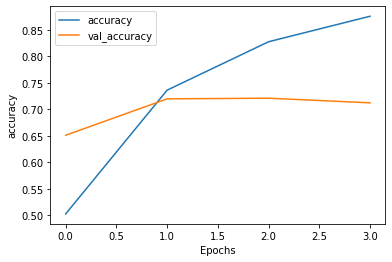

In [126]:
plot_graphs(history, 'accuracy')

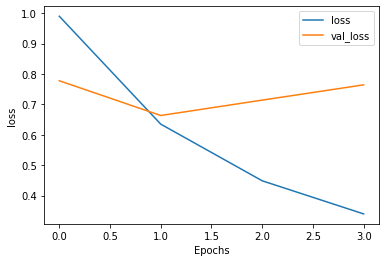

In [127]:
plot_graphs(history, 'loss')

In [129]:
# 加载模型并评估
tempModel = tf.keras.models.load_model('model_lstm_attention.h5')
test_loss, test_acc = tempModel.evaluate(test_x, test_y, batch_size=BATCH_SIZE)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

ValueError: Unknown layer: AttentionLayer